# Supervised Loss

**Goal:** Qualitatively, it seems like having the slot "know" about where the circle center and radius lives seems like a nice thing to have.

Lukas suggested starting from a "warm start", and I agree, this seems like smth nice to have!

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
from torch.nn import init
import torch.nn.functional as F

# IO pkgs
import yaml, json
from glob import glob

# custom code
import os
os.sys.path.append('code')
from plotting import plot_kslots, plot_kslots_iters
from data import make_batch
from train import hungarian_matching, img_entropy
from model import SlotAttentionPosEmbed

%load_ext autoreload
%autoreload 2

### Step 1: Model 

Define a model architecture, and load in a "warm" starting point.

In [2]:
cID_prev = 'learn-init-warm2'

In [3]:
with open(f'code/models/{cID_prev}/loss.json') as f:
    ld = pd.Series(json.load(f))

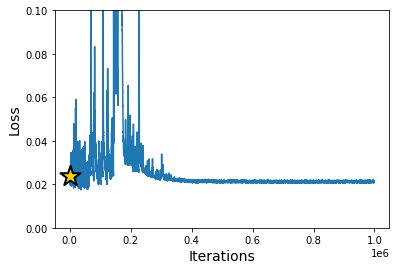

In [4]:
roll_avg = 100
plt.plot(ld.rolling(roll_avg).mean()[roll_avg:])
plt.ylim(0,.1)

i=0
plt.scatter(i,ld[i],450,marker="*",color='gold',ec='k',zorder=10,lw=2)

plt.xlabel('Iterations',fontsize=14)
plt.ylabel('Loss',fontsize=14)
plt.show()

In [5]:
device='cuda:0'

In [6]:
with open(f'code/configs/{cID_prev}.yaml') as f:
    cd = yaml.safe_load(f)


hps = cd['hps']
hps['device'] = device
hps['learn_slot_feat'] = True

kwargs = cd['data']
kwargs['device'] = device
hps

{'hidden_dim': 16,
 'k_slots': 3,
 'query_dim': 128,
 'softmax_T': 'default',
 'learn_init': True,
 'device': 'cuda:0',
 'learn_slot_feat': True}

In [7]:
m = SlotAttentionPosEmbed(**hps).to(device)

In [8]:
lastIter = 400_000
modelToLoad = f'code/models/{cID_prev}/m_{lastIter}.pt'
print(f'Starting from an earlier training',lastIter)

m.load_state_dict(torch.load(modelToLoad,map_location=device),strict=False)

Starting from an earlier training 400000


_IncompatibleKeys(missing_keys=['final_mlp.0.weight', 'final_mlp.0.bias', 'final_mlp.2.weight', 'final_mlp.2.bias'], unexpected_keys=[])

Initialize the last layer of the network to match the means of the distribution.

In [9]:
m.final_mlp[2].bias

Parameter containing:
tensor([ 0.1482, -0.1984, -0.1000], device='cuda:0', requires_grad=True)

In [10]:
torch.nn.init.constant_(m.final_mlp[2].bias[:2],0)
torch.nn.init.constant_(m.final_mlp[2].bias[-1],0.17)

tensor(0.1700, device='cuda:0', grad_fn=<AsStridedBackward0>)

In [11]:
m.final_mlp[2].bias #= torch.Tensor([0,0,.17])

Parameter containing:
tensor([0.0000, 0.0000, 0.1700], device='cuda:0', requires_grad=True)

In [12]:
cID = 'li-Q128-warm-sup'

modelDir = f'code/models/{cID}'
figDir = f'code/figures/{cID}'

# for d in [modelDir,figDir]:
#     os.mkdir(d)

The history saving thread hit an unexpected error (OperationalError('disk I/O error')).History will not be written to the database.


In [13]:
bs = 100
X, Y, mask = make_batch(N_events=bs, **kwargs)

/gpfs/slac/atlas/fs1/d/nhartman/Slot Attention/code/data.py:94: RuntimeWarning: invalid value encountered in true_divide
  eventMasks = np.where(eventHistograms>0,eventMasks/eventHistograms,eventMasks)


In [14]:
queries, att, Y_pred = m(X)

In [15]:
k_slots = 3
max_n_rings = 2
resolution = (32,32)

In [16]:
mask.shape

torch.Size([100, 2, 32, 32])

In [17]:
def comb_loss(att,flat_mask,Y=None,Y_pred=None,alpha=1):
    '''
    Goal: Given a NN that predicts both an occupancy mask
    and a center and radius for each slot, combine these terms 
    into a combined loss function:
    
    L = L_bce + alpha * L_mse
    
    Note: This function should be general enough to either calculate
    the losses of all the combinations of slots and targets or just
    the single loss between the loss and the chosen target
        
    '''
    
    att_ext  = torch.tile(att.unsqueeze(2), dims=(1,1,max_n_rings,1)) 
    mask_ext = torch.tile(flat_mask.unsqueeze(1),dims=(1,k_slots,1,1)) 
    
    l_bce = F.binary_cross_entropy(att_ext,mask_ext,reduction='none').mean(axis=-1)
    
    if alpha == 0:
        return l_bce
    
    else:
    
        # Calc MSEmse_loss(Y,Y_pred)
        l_mse = torch.nn.MSELoss(reduction='none')(Y_pred.unsqueeze(2), Y.unsqueeze(1)).mean(axis=-1)
        return l_bce + alpha * l_mse
    

In [18]:
flat_mask = torch.reshape(mask,(bs, max_n_rings, np.prod(resolution)))

pairwise_cost = comb_loss(att, flat_mask,Y,Y_pred)
with torch.no_grad():
    indices = hungarian_matching(pairwise_cost)
    
pairwise_cost.shape

/opt/conda/lib/python3.8/site-packages/torch/nn/modules/loss.py:520: UserWarning: Using a target size (torch.Size([100, 1, 2, 3])) that is different to the input size (torch.Size([100, 3, 1, 3])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


torch.Size([100, 3, 2])

In [19]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.patches import Circle

def plot_chosen_slots(losses, mask, att_img, Y_true, Y_pred, color='C0',cmap='Blues',figname=''):
    n_rings = att_img.shape[0]
    fig, axs = plt.subplots(1,n_rings+2,figsize=(3*(n_rings + 2) ,2.5))

    for k,v in losses.items():
        axs[0].plot(v,label=k)
    axs[0].set_xlabel('Iters')
    axs[0].set_ylabel('Loss')
    axs[0].legend()
    
    imgs   = [mask] + [att_img[i] for i in range(n_rings)]
    titles = ['Target']+[f'Slot {i}' for i in range(n_rings)]
    extent = [-0.5, 0.5]*2
    for i, (ax,img,title) in enumerate(zip(axs[1:],imgs, titles)):
        
        im = ax.imshow(img.detach().cpu().numpy(),cmap=cmap,
                       extent=extent,origin='lower') #,vmin=0,vmax=1)

        divider = make_axes_locatable(ax)
        cax = divider.append_axes('right', size='5%', pad=0.05)
        fig.colorbar(im, cax=cax, orientation='vertical')

        ax.set_title(title)
        

    # Add on the target image
    axi = axs[1]
    c_true = 'r'
    c_pred = 'k'
    for yi in Y_true.cpu().numpy():
    
        axi.scatter(*yi[:2],marker='x',color=c_true)
        circle = Circle(yi[:2],yi[2],fill=False,color=c_true)
        axi.add_patch(circle)
        
        axi.set_xlim(-0.5,0.5)
        axi.set_ylim(-0.5,0.5)
    
    for axi,yi,oi in zip(axs[2:],Y_true.cpu().numpy(),Y_pred.detach().cpu().numpy()):
        
        axi.scatter(*yi[:2],marker='x',color=c_true)
        circle = Circle(yi[:2],yi[2],fill=False,color=c_true)
        axi.add_patch(circle)
        
        axi.scatter(*oi[:2],marker='x',color=c_pred)
        circle = Circle(oi[:2],oi[2],fill=False,color=c_pred)
        axi.add_patch(circle)

        axi.set_xlim(-0.5,0.5)
        axi.set_ylim(-0.5,0.5)
        
    if figname:
        plt.savefig(figname)

    plt.show()
    plt.close()

In [20]:
def train(model, 
          Ntrain = 5000, 
          bs=32, 
          lr=3e-4,
          warmup_steps=5_000,
          alpha=1,
          losses = {'tot':[],'kl':[],'mse':[]},
          kwargs={'isRing': True, 'N_clusters':2},
          device='cpu',
          plot_every=250, 
          save_every=1000,
          color='C0',cmap='Blues',
          modelDir='.',figDir='',showImg=True):
    '''
    train -- arguments copied from Lukas's fct (see train.py)
    '''

    # Learning rate schedule config
    base_learning_rate = lr
    
    opt = torch.optim.Adam(model.parameters(), base_learning_rate)
    
    model.train()
    
    k_slots = model.k_slots
    max_n_rings = kwargs['N_clusters']
    resolution = model.resolution
    kwargs['device'] = device

    start = len(losses['tot'])
    for i in range(start,start+Ntrain):

        learning_rate = base_learning_rate * 0.5 * (1 + np.cos(np.pi * i / Ntrain))
        if i < warmup_steps:
            learning_rate *= (i / warmup_steps)
        
        opt.param_groups[0]['lr'] = learning_rate
        
        X, Y, mask = make_batch(N_events=bs, **kwargs)
        
        queries, att, Y_pred = model(X)
            
        # Reshape the target mask to be flat in the pixels (same shape as att)
        flat_mask = mask.reshape(-1,max_n_rings, np.prod(resolution))      
        with torch.no_grad():
            
            pairwise_cost = comb_loss(att,flat_mask,Y,Y_pred,alpha)
            indices = hungarian_matching(pairwise_cost)

        # Apply the sorting to the predict
        bis=torch.arange(bs).to(device)
        indices=indices.to(device)

        '''
        KL divergence loss
        '''
        slots_sorted = torch.cat([att[bis,indices[:,0,ri]].unsqueeze(1) for ri in range(max_n_rings)],dim=1)
        rings_sorted = torch.cat([flat_mask[bis,indices[:,1,ri]].unsqueeze(1) for ri in range(max_n_rings)],dim=1)

        l_bce = F.binary_cross_entropy(slots_sorted,rings_sorted,reduction='none').sum(axis=1).mean(axis=1)
        l_ent = img_entropy(mask)
        l_kl = (l_bce - l_ent).mean()
        
        '''
        MSE loss
        '''
        Y_pred_sorted = torch.cat([Y_pred[bis,indices[:,0,ri]].unsqueeze(1) for ri in range(max_n_rings)],dim=1)
        Y_true_sorted = torch.cat([Y[bis,indices[:,1,ri]].unsqueeze(1) for ri in range(max_n_rings)],dim=1)

        l_mse = torch.nn.MSELoss(reduction='none')(Y_pred_sorted,Y_true_sorted).sum(axis=1).mean()
    
        # Calculate the loss
        li = l_kl + alpha*l_mse
        
        li.backward()
        clip_val=1
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip_val)
        opt.step()
        opt.zero_grad()

        losses['tot'].append(float(li))
        losses['kl'].append(float(l_kl))
        losses['mse'].append(float(l_mse))
        
        if i % plot_every == 0:
            print('iter',i,', loss',li.detach().cpu().numpy(),', lr',opt.param_groups[0]['lr'])
            
            iEvt = 0
            att_sorted  = torch.cat([att[bis,indices[:,0,ri]].unsqueeze(1) for ri in range(max_n_rings)],dim=1)
            
            att_img = att_sorted[iEvt].reshape(max_n_rings,*resolution)

            plot_chosen_slots(losses,mask[iEvt].sum(axis=0), att_img,
                              Y_true_sorted[iEvt],Y_pred_sorted[iEvt])
            
        if (i % save_every == 0) and modelDir:
            torch.save(model.state_dict(), f'{modelDir}/m_{i}.pt')
            with open(f'{modelDir}/loss.json','w') as f:
                json.dump(losses, f)

    model.eval()
    return model,losses

/opt/conda/lib/python3.8/site-packages/torch/nn/modules/loss.py:520: UserWarning: Using a target size (torch.Size([256, 1, 2, 3])) that is different to the input size (torch.Size([256, 3, 1, 3])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


iter 0 , loss 0.024420822 , lr 0.0


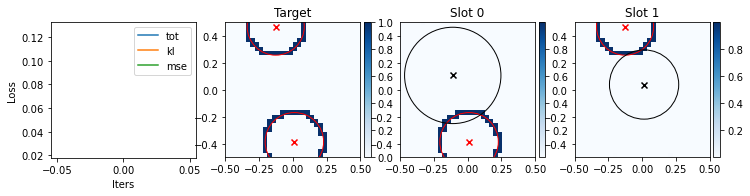

iter 100 , loss 0.018413385 , lr 5.999907472934369e-06


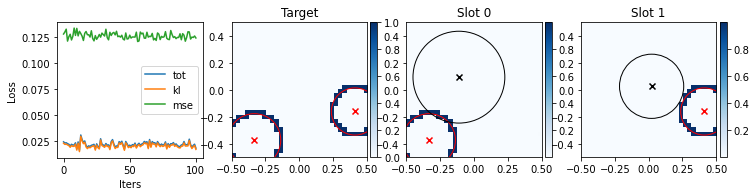

iter 200 , loss 0.02391246 , lr 1.1999259794889963e-05


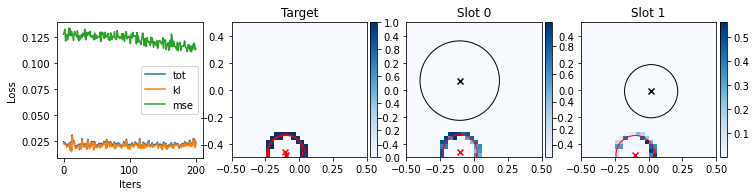

iter 300 , loss 0.025198752 , lr 1.7997501871962002e-05


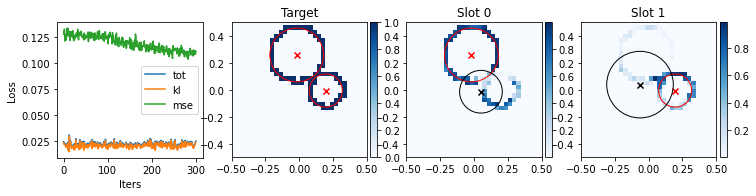

iter 400 , loss 0.02564919 , lr 2.3994078724388778e-05


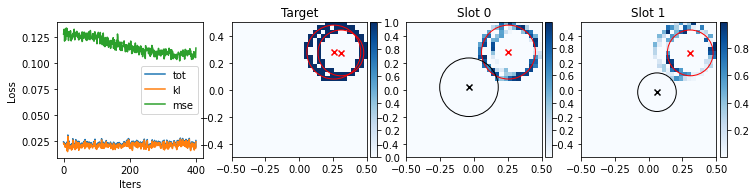

iter 500 , loss 0.027145937 , lr 2.9988435543610846e-05


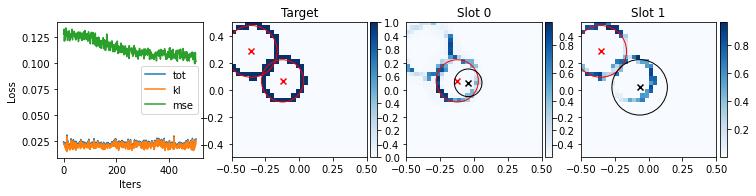

iter 600 , loss 0.02439654 , lr 3.5980017749315456e-05


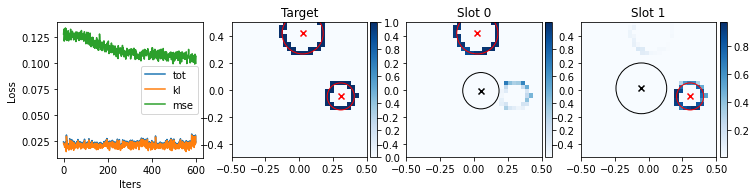

iter 700 , loss 0.020667173 , lr 4.19682710464613e-05


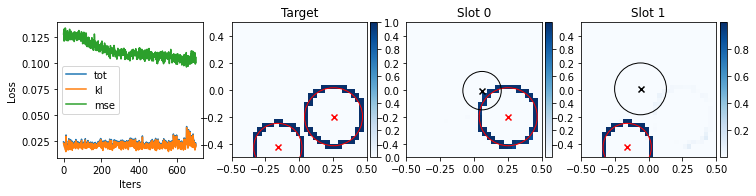

iter 800 , loss 0.022798676 , lr 4.7952641482278515e-05


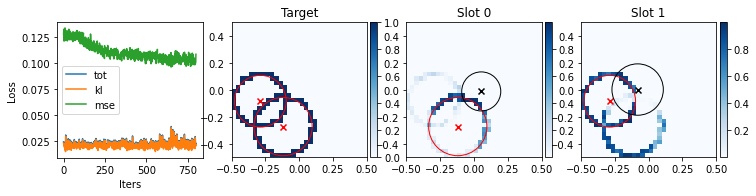

iter 900 , loss 0.02108296 , lr 5.393257550323929e-05


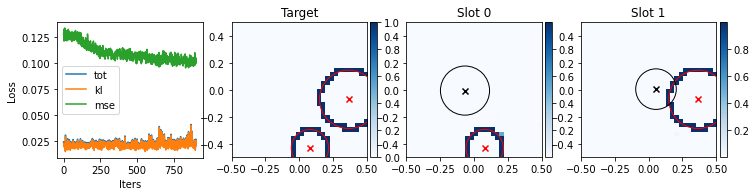

iter 1000 , loss 0.020713236 , lr 5.9907520011993834e-05


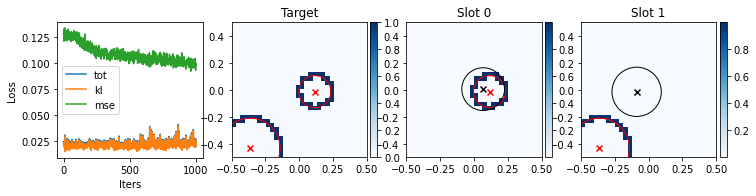

iter 1100 , loss 0.024162257 , lr 6.587692242426705e-05


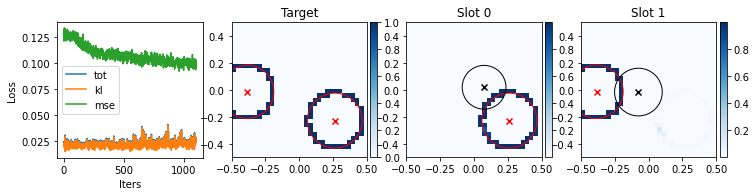

iter 1200 , loss 0.02991838 , lr 7.184023072571087e-05


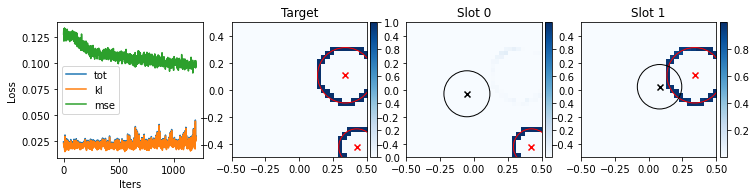

iter 1300 , loss 0.023681123 , lr 7.779689352870732e-05


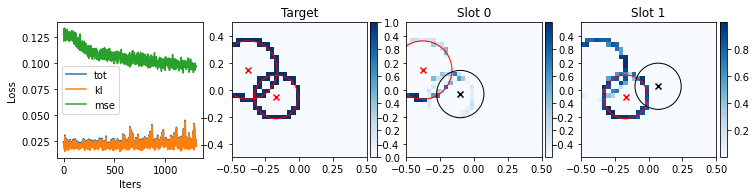

iter 1400 , loss 0.024980612 , lr 8.374636012911756e-05


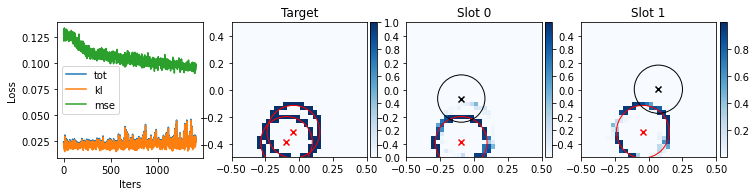

iter 1500 , loss 0.029822273 , lr 8.968808056297168e-05


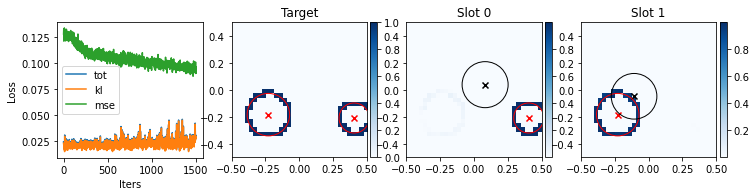

iter 1600 , loss 0.035902347 , lr 9.562150566309494e-05


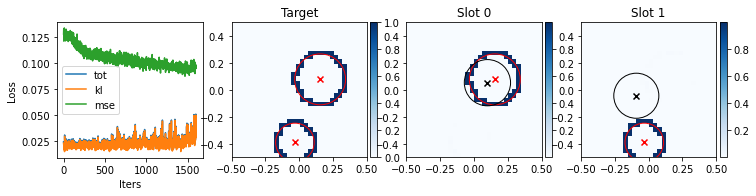

iter 1700 , loss 0.02499085 , lr 0.00010154608711566472


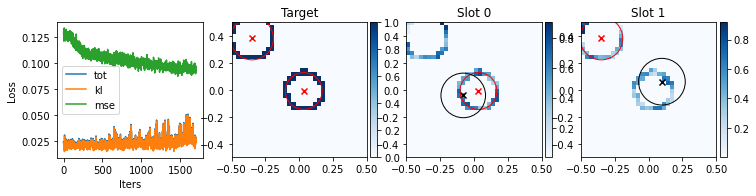

iter 1800 , loss 0.023295708 , lr 0.00010746127751669408


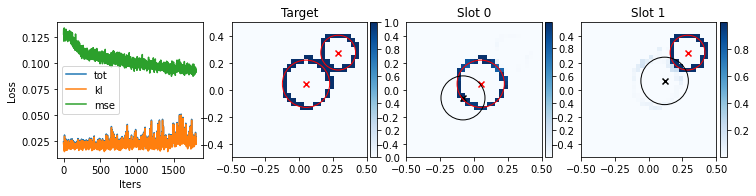

iter 1900 , loss 0.033297557 , lr 0.00011336653042843675


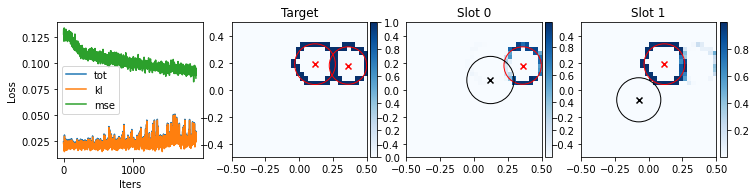

iter 2000 , loss 0.023877436 , lr 0.00011926130043570826


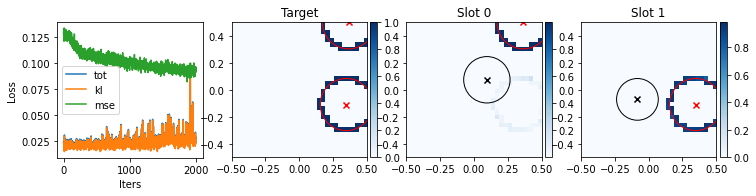

In [ ]:
m,losses = train(m, Ntrain = 40_000, bs=256,  lr=3e-4, warmup_steps=5_000,
                 alpha=.01, device=device,plot_every=100)